# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
import scipy.stats as stat
from sklearn.preprocessing import LabelEncoder

# Loading the Data and Selecting the Features

### Import Data

In [7]:
loan_data_inputs_train = pd.read_csv('loan_data_inputs_train.csv', index_col = 0)
loan_data_targets_train = pd.read_csv('loan_data_targets_train.csv', index_col = 0, header = None)
loan_data_inputs_test = pd.read_csv('loan_data_inputs_test.csv', index_col = 0)
loan_data_targets_test = pd.read_csv('loan_data_targets_test.csv', index_col = 0, header = None)

# Convert Data Type

In [10]:
# Convert boolean columns to integers (True=1, False=0)
loan_data_inputs_train = loan_data_inputs_train.astype({col: 'int64' for col in loan_data_inputs_train.select_dtypes('bool').columns})

In [11]:

# Convert columns containing numeric strings to float where possible
def convert_to_numeric(df):
    for col in df.columns:
        try:
            df[col] = pd.to_numeric(df[col])
        except ValueError:
            # Skip if conversion is not possible
            continue
convert_to_numeric(loan_data_inputs_train)

# Identify object columns (categorical)
object_columns = loan_data_inputs_train.select_dtypes('object').columns

# Step 1: Reduce high cardinality by grouping rare categories into "Other"
def reduce_cardinality(col, threshold=0.01):
    counts = col.value_counts(normalize=True)
    rare_labels = counts[counts < threshold].index
    return col.apply(lambda x: 'Other' if x in rare_labels else x)

for col in object_columns:
    if col in loan_data_inputs_train:
        loan_data_inputs_train[col] = reduce_cardinality(loan_data_inputs_train[col])

# Step 2: Use Label Encoding for all remaining categorical columns (no one-hot encoding)
label_encoders = {}
for col in object_columns:
    if col in loan_data_inputs_train.columns:
        le = LabelEncoder()
        loan_data_inputs_train[col] = le.fit_transform(loan_data_inputs_train[col].astype(str))
        label_encoders[col] = le  # Save encoders if needed for future use

# Convert any remaining columns to numeric if possible
loan_data_inputs_train = loan_data_inputs_train.apply(pd.to_numeric, errors='coerce')

# Fill NaN values with 0 or another strategy if needed
loan_data_inputs_train.fillna(0, inplace=True)

# Verify the number of columns (should be 324)
print(f"Number of columns after encoding: {loan_data_inputs_train.shape[1]}")

# Ensure that column names are kept the same
original_columns = loan_data_inputs_train.columns.tolist()[:324]  # Truncate if needed to keep only 324 columns
loan_data_inputs_train = loan_data_inputs_train[original_columns]

# Continue with logistic regression

Number of columns after encoding: 324


### Explore Data

In [13]:
loan_data_inputs_train.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>=86
427211,427211,12796369,14818505,24000,24000,24000.0,0,8.90,762.08,0,...,1,0,0,1,0,0,0,0,0,0
206088,206088,1439740,1691948,10000,10000,10000.0,0,14.33,343.39,2,...,0,0,0,1,0,0,0,0,0,0
136020,136020,5214749,6556909,20425,20425,20425.0,0,8.90,648.56,0,...,0,0,0,1,0,0,0,0,0,0
412305,412305,13827698,15890016,17200,17200,17200.0,0,16.59,609.73,3,...,0,0,0,1,0,0,0,0,0,0
36159,36159,422455,496525,8400,8400,7450.0,0,12.84,282.40,2,...,0,1,0,1,0,0,0,0,0,0


In [17]:
loan_data_targets_train.head()

,1
0,
427211,1
206088,1
136020,1
412305,0
36159,0


In [19]:
loan_data_inputs_train.shape

(373028, 324)

In [21]:
loan_data_targets_train.shape

(373028, 1)

In [23]:
loan_data_inputs_test.shape

(93257, 324)

In [25]:
loan_data_targets_test.shape

(93257, 1)

### Selecting the Features

In [27]:
# Here we select a limited set of input variables in a new dataframe.
inputs_train_with_ref_cat = loan_data_inputs_train.loc[: , ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'addr_state:NM_VA',
'addr_state:NY',
'addr_state:OK_TN_MO_LA_MD_NC',
'addr_state:CA',
'addr_state:UT_KY_AZ_NJ',
'addr_state:AR_MI_PA_OH_MN',
'addr_state:RI_MA_DE_SD_IN',
'addr_state:GA_WA_OR',
'addr_state:WI_MT',
'addr_state:TX',
'addr_state:IL_CT',
'addr_state:KS_SC_CO_VT_AK_MS',
'addr_state:WV_NH_WY_DC_ME_ID',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:oth__med__vacation',
'purpose:major_purch__car__home_impr',
'initial_list_status:f',
'initial_list_status:w',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'mths_since_issue_d:<38',
'mths_since_issue_d:38-39',
'mths_since_issue_d:40-41',
'mths_since_issue_d:42-48',
'mths_since_issue_d:49-52',
'mths_since_issue_d:53-64',
'mths_since_issue_d:65-84',
'mths_since_issue_d:>84',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'mths_since_earliest_cr_line:141-164',
'mths_since_earliest_cr_line:165-247',
'mths_since_earliest_cr_line:248-270',
'mths_since_earliest_cr_line:271-352',
'mths_since_earliest_cr_line:>352',
'delinq_2yrs:0',
'delinq_2yrs:1-3',
'delinq_2yrs:>=4',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
'open_acc:0',
'open_acc:1-3',
'open_acc:4-12',
'open_acc:13-17',
'open_acc:18-22',
'open_acc:23-25',
'open_acc:26-30',
'open_acc:>=31',
'pub_rec:0-2',
'pub_rec:3-4',
'pub_rec:>=5',
'total_acc:<=27',
'total_acc:28-51',
'total_acc:>=52',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
'total_rev_hi_lim:<=5K',
'total_rev_hi_lim:5K-10K',
'total_rev_hi_lim:10K-20K',
'total_rev_hi_lim:20K-30K',
'total_rev_hi_lim:30K-40K',
'total_rev_hi_lim:40K-55K',
'total_rev_hi_lim:55K-95K',
'total_rev_hi_lim:>95K',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
'mths_since_last_delinq:Missing',
'mths_since_last_delinq:0-3',
'mths_since_last_delinq:4-30',
'mths_since_last_delinq:31-56',
'mths_since_last_delinq:>=57',
'mths_since_last_record:Missing',
'mths_since_last_record:0-2',
'mths_since_last_record:3-20',
'mths_since_last_record:21-31',
'mths_since_last_record:32-80',
'mths_since_last_record:81-86',
'mths_since_last_record:>=86'
]]

In [29]:
# Here we store the names of the reference category dummy variables in a list.
ref_categories = ['grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'initial_list_status:f',
'term:60',
'emp_length:0',
'mths_since_issue_d:>84',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'delinq_2yrs:>=4',
'inq_last_6mths:>6',
'open_acc:0',
'pub_rec:0-2',
'total_acc:<=27',
'acc_now_delinq:0',
'total_rev_hi_lim:<=5K',
'annual_inc:<20K',
'dti:>35',
'mths_since_last_delinq:0-3',
'mths_since_last_record:0-2']

In [31]:
inputs_train = inputs_train_with_ref_cat.drop(ref_categories, axis = 1)
# From the dataframe with input variables, we drop the variables with variable names in the list with reference categories. 
inputs_train.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,...,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>=86
427211,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
206088,0,0,1,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
136020,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
412305,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
36159,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0


# PD Model Estimation

## Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [35]:
reg = LogisticRegression()
# We create an instance of an object from the 'LogisticRegression' class.

In [37]:
pd.options.display.max_rows = None
# Sets the pandas dataframe options to display all columns/ rows.

In [39]:
reg.fit(inputs_train, loan_data_targets_train)
# Estimates the coefficients of the object from the 'LogisticRegression' class
# with inputs (independent variables) contained in the first dataframe
# and targets (dependent variables) contained in the second dataframe.

C:\Users\Adali\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [41]:
reg.intercept_
# Displays the intercept contain in the estimated ("fitted") object from the 'LogisticRegression' class.

array([-0.42331201])

In [49]:
reg.coef_
# Displays the coefficients contained in the estimated ("fitted") object from the 'LogisticRegression' class.

array([[ 0.95661301,  0.75097701,  0.56972441,  0.38891223,  0.23414829,
         0.06019956,  0.09107233,  0.10357338,  0.04316737,  0.06959456,
         0.0663156 ,  0.0705994 ,  0.08725677,  0.14685286,  0.11382941,
         0.19630467,  0.24234602,  0.23418572,  0.27480927,  0.33596615,
         0.49189205,  0.08288705, -0.01565145,  0.27378904,  0.17163237,
         0.17781097,  0.2315079 ,  0.05134325,  0.07191667,  0.10953448,
         0.13427551,  0.10208314,  0.06871146,  0.12917567,  1.12614334,
         0.93436006,  0.83601067,  0.64101598,  0.48044423,  0.235619  ,
        -0.01599717,  0.97470617,  0.62429586,  0.36109087,  0.15109467,
         0.07660743,  0.05822424,  0.10462854,  0.1417057 ,  0.14762215,
        -0.03517891, -0.06261865,  0.28779861,  0.14551345, -0.06341245,
         0.07111582, -0.03928697, -0.06285538, -0.08920642, -0.07380393,
        -0.04993862, -0.10534915,  0.13119273,  0.08966502, -0.02132435,
         0.03170864,  0.16152847,  0.04383066,  0.0

In [51]:
feature_name = inputs_train.columns.values
# Stores the names of the columns of a dataframe in a variable.

In [53]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Creates a dataframe with a column titled 'Feature name' and row values contained in the 'feature_name' variable.
summary_table['Coefficients'] = np.transpose(reg.coef_)
# Creates a new column in the dataframe, called 'Coefficients',
# with row values the transposed coefficients from the 'LogisticRegression' object.
summary_table.index = summary_table.index + 1
# Increases the index of every row of the dataframe with 1.
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]
# Assigns values of the row with index 0 of the dataframe.
summary_table = summary_table.sort_index()
# Sorts the dataframe by index.
summary_table

,Feature name,Coefficients
0,Intercept,-0.423312
1,grade:A,0.956613
2,grade:B,0.750977
3,grade:C,0.569724
4,grade:D,0.388912
5,grade:E,0.234148
6,grade:F,0.060200
7,home_ownership:OWN,0.091072
8,home_ownership:MORTGAGE,0.103573
9,addr_state:NM_VA,0.043167


## Build a Logistic Regression Model with P-Values

In [55]:
# P values for sklearn logistic regression.

# Class to display p-values for logistic regression in sklearn.

from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        
        #### Get p-values for the fitted model ####
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores] ### two tailed test for p-values
        
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        #self.z_scores = z_scores
        self.p_values = p_values
        #self.sigma_estimates = sigma_estimates
        #self.F_ij = F_ij

In [57]:
from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)

    def fit(self,X,y):
        self.model.fit(X,y)
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X)
        Cramer_Rao = np.linalg.inv(F_ij)
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores]
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values

In [59]:
reg = LogisticRegression_with_p_values()
# We create an instance of an object from the newly created 'LogisticRegression_with_p_values()' class.

In [61]:
reg.fit(inputs_train, loan_data_targets_train)
# Estimates the coefficients of the object from the 'LogisticRegression' class
# with inputs (independent variables) contained in the first dataframe
# and targets (dependent variables) contained in the second dataframe.

C:\Users\Adali\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [63]:
# Same as above.
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table

,Feature name,Coefficients
0,Intercept,-0.423312
1,grade:A,0.956613
2,grade:B,0.750977
3,grade:C,0.569724
4,grade:D,0.388912
5,grade:E,0.234148
6,grade:F,0.060200
7,home_ownership:OWN,0.091072
8,home_ownership:MORTGAGE,0.103573
9,addr_state:NM_VA,0.043167


In [65]:
# This is a list.
p_values = reg.p_values
# We take the result of the newly added method 'p_values' and store it in a variable 'p_values'.

In [67]:
# Add the intercept for completeness.
p_values = np.append(np.nan, np.array(p_values))
# We add the value 'NaN' in the beginning of the variable with p-values.

In [69]:
summary_table['p_values'] = p_values
# In the 'summary_table' dataframe, we add a new column, called 'p_values', containing the values from the 'p_values' variable.

In [71]:
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-0.423312,NaN
1,grade:A,0.956613,1.498113e-25
2,grade:B,0.750977,4.815936e-34
3,grade:C,0.569724,2.995418e-23
4,grade:D,0.388912,1.003991e-12
5,grade:E,0.234148,1.668800e-06
6,grade:F,0.060200,2.371438e-01
7,home_ownership:OWN,0.091072,6.524415e-06
8,home_ownership:MORTGAGE,0.103573,3.427619e-16
9,addr_state:NM_VA,0.043167,1.777073e-01


In [73]:
# We are going to remove some features, the coefficients for all or almost all of the dummy variables for which,
# are not tatistically significant.

# We do that by specifying another list of dummy variables as reference categories, and a list of variables to remove.
# Then, we are going to drop the two datasets from the original list of dummy variables.

# Variables
inputs_train_with_ref_cat = loan_data_inputs_train.loc[: , ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'addr_state:NM_VA',
'addr_state:NY',
'addr_state:OK_TN_MO_LA_MD_NC',
'addr_state:CA',
'addr_state:UT_KY_AZ_NJ',
'addr_state:AR_MI_PA_OH_MN',
'addr_state:RI_MA_DE_SD_IN',
'addr_state:GA_WA_OR',
'addr_state:WI_MT',
'addr_state:TX',
'addr_state:IL_CT',
'addr_state:KS_SC_CO_VT_AK_MS',
'addr_state:WV_NH_WY_DC_ME_ID',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:oth__med__vacation',
'purpose:major_purch__car__home_impr',
'initial_list_status:f',
'initial_list_status:w',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'mths_since_issue_d:<38',
'mths_since_issue_d:38-39',
'mths_since_issue_d:40-41',
'mths_since_issue_d:42-48',
'mths_since_issue_d:49-52',
'mths_since_issue_d:53-64',
'mths_since_issue_d:65-84',
'mths_since_issue_d:>84',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'mths_since_earliest_cr_line:141-164',
'mths_since_earliest_cr_line:165-247',
'mths_since_earliest_cr_line:248-270',
'mths_since_earliest_cr_line:271-352',
'mths_since_earliest_cr_line:>352',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
'mths_since_last_delinq:Missing',
'mths_since_last_delinq:0-3',
'mths_since_last_delinq:4-30',
'mths_since_last_delinq:31-56',
'mths_since_last_delinq:>=57',
'mths_since_last_record:Missing',
'mths_since_last_record:0-2',
'mths_since_last_record:3-20',
'mths_since_last_record:21-31',
'mths_since_last_record:32-80',
'mths_since_last_record:81-86',
'mths_since_last_record:>=86'
]]

ref_categories = ['grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'initial_list_status:f',
'term:60',
'emp_length:0',
'mths_since_issue_d:>84',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'annual_inc:<20K',
'dti:>35',
'mths_since_last_delinq:0-3',
'mths_since_last_record:0-2']

In [75]:
inputs_train = inputs_train_with_ref_cat.drop(ref_categories, axis = 1)
inputs_train.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,...,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>=86
427211,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
206088,0,0,1,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
136020,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
412305,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
36159,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0


In [83]:
# Here we run a new model.
reg2 = LogisticRegression_with_p_values()
reg2.fit(inputs_train, loan_data_targets_train)

C:\Users\Adali\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [84]:
feature_name = inputs_train.columns.values

In [85]:
# Same as above.
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg2.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg2.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table

,Feature name,Coefficients
0,Intercept,-0.445985
1,grade:A,0.944051
2,grade:B,0.732144
3,grade:C,0.549044
4,grade:D,0.373379
5,grade:E,0.219520
6,grade:F,0.049873
7,home_ownership:OWN,0.096256
8,home_ownership:MORTGAGE,0.105095
9,addr_state:NM_VA,0.044426


In [89]:
# We add the 'p_values' here, just as we did before.
p_values = reg2.p_values
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table
# Here we get the results for our final PD model.

,Feature name,Coefficients,p_values
0,Intercept,-0.445985,NaN
1,grade:A,0.944051,4.229369e-25
2,grade:B,0.732144,1.440979e-32
3,grade:C,0.549044,7.371959e-22
4,grade:D,0.373379,5.637468e-12
5,grade:E,0.219520,5.131963e-06
6,grade:F,0.049873,3.185217e-01
7,home_ownership:OWN,0.096256,1.835873e-06
8,home_ownership:MORTGAGE,0.105095,9.223599e-17
9,addr_state:NM_VA,0.044426,1.648468e-01


In [91]:
import pickle

In [93]:
pickle.dump(reg2, open('pd_model.sav', 'wb'))
# Here we export our model to a 'SAV' file with file name 'pd_model.sav'.

# PD Model Validation (Test)

### Out-of-sample validation (test)

In [97]:
# Here, from the dataframe with inputs for testing, we keep the same variables that we used in our final PD model.
inputs_test_with_ref_cat = loan_data_inputs_test.loc[: , ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'addr_state:NM_VA',
'addr_state:NY',
'addr_state:OK_TN_MO_LA_MD_NC',
'addr_state:CA',
'addr_state:UT_KY_AZ_NJ',
'addr_state:AR_MI_PA_OH_MN',
'addr_state:RI_MA_DE_SD_IN',
'addr_state:GA_WA_OR',
'addr_state:WI_MT',
'addr_state:TX',
'addr_state:IL_CT',
'addr_state:KS_SC_CO_VT_AK_MS',
'addr_state:WV_NH_WY_DC_ME_ID',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:oth__med__vacation',
'purpose:major_purch__car__home_impr',
'initial_list_status:f',
'initial_list_status:w',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'mths_since_issue_d:<38',
'mths_since_issue_d:38-39',
'mths_since_issue_d:40-41',
'mths_since_issue_d:42-48',
'mths_since_issue_d:49-52',
'mths_since_issue_d:53-64',
'mths_since_issue_d:65-84',
'mths_since_issue_d:>84',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'mths_since_earliest_cr_line:141-164',
'mths_since_earliest_cr_line:165-247',
'mths_since_earliest_cr_line:248-270',
'mths_since_earliest_cr_line:271-352',
'mths_since_earliest_cr_line:>352',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
'mths_since_last_delinq:Missing',
'mths_since_last_delinq:0-3',
'mths_since_last_delinq:4-30',
'mths_since_last_delinq:31-56',
'mths_since_last_delinq:>=57',
'mths_since_last_record:Missing',
'mths_since_last_record:0-2',
'mths_since_last_record:3-20',
'mths_since_last_record:21-31',
'mths_since_last_record:32-80',
'mths_since_last_record:81-86',
'mths_since_last_record:>=86'
]]

In [99]:
# And here, in the list below, we keep the variable names for the reference categories,
# only for the variables we used in our final PD model.
ref_categories = ['grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'initial_list_status:f',
'term:60',
'emp_length:0',
'mths_since_issue_d:>84',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'annual_inc:<20K',
'dti:>35',
'mths_since_last_delinq:0-3',
'mths_since_last_record:0-2']

In [101]:
inputs_test = inputs_test_with_ref_cat.drop(ref_categories, axis = 1)
inputs_test.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,...,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>=86
362514,False,False,True,False,False,False,False,True,0,False,...,1,0,0,0,1,0,0,0,0,0
288564,False,False,False,False,True,False,False,True,0,False,...,0,0,0,0,1,0,0,0,0,0
213591,False,False,True,False,False,False,False,True,0,False,...,0,0,1,0,1,0,0,0,0,0
263083,False,False,True,False,False,False,False,True,0,False,...,1,0,0,0,1,0,0,0,0,0
165001,True,False,False,False,False,False,False,True,0,False,...,0,0,1,0,1,0,0,0,0,0


In [103]:
y_hat_test = reg2.model.predict(inputs_test)
# Calculates the predicted values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument.

In [105]:
y_hat_test
# This is an array of predicted discrete classess (in this case, 0s and 1s).

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [107]:
y_hat_test_proba = reg2.model.predict_proba(inputs_test)
# Calculates the predicted probability values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument.

In [109]:
y_hat_test_proba
# This is an array of arrays of predicted class probabilities for all classes.
# In this case, the first value of every sub-array is the probability for the observation to belong to the first class, i.e. 0, (prob of being a bad borrower)
# and the second value is the probability for the observation to belong to the first class, i.e. 1. (prob of being a good borrower)

array([[0.07576417, 0.92423583],
       [0.14980296, 0.85019704],
       [0.11484452, 0.88515548],
       ...,
       [0.02692721, 0.97307279],
       [0.04022367, 0.95977633],
       [0.04793433, 0.95206567]])

In [111]:
y_hat_test_proba[:][:,1]
# Here we take all the arrays in the array, and from each array, we take all rows, and only the element with index 1,
# that is, the second element.
# In other words, we take only the probabilities for being 1.

array([0.92423583, 0.85019704, 0.88515548, ..., 0.97307279, 0.95977633,
       0.95206567])

In [113]:
y_hat_test_proba = y_hat_test_proba[: ][: , 1]
# We store these probabilities in a variable.

In [115]:
y_hat_test_proba
# This variable contains an array of probabilities of being 1. (the array y_hat_test_proba only contains the prob of being a good borrower)

array([0.92423583, 0.85019704, 0.88515548, ..., 0.97307279, 0.95977633,
       0.95206567])

In [117]:
loan_data_targets_test_temp = loan_data_targets_test

In [119]:
loan_data_targets_test_temp.reset_index(drop = True, inplace = True)
# We reset the index of a dataframe.

In [121]:
df_actual_predicted_probs = pd.concat([loan_data_targets_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
# Concatenates two dataframes. (the laon_data_targets_test and the array array y_hat_test_proba that only contains the prob of being a good borrower)

In [123]:
df_actual_predicted_probs.shape

(93257, 2)

In [125]:
df_actual_predicted_probs.columns = ['loan_data_targets_test', 'y_hat_test_proba']

In [127]:
df_actual_predicted_probs.index = loan_data_inputs_test.index
# Makes the index of one dataframe equal to the index of another dataframe.

In [129]:
df_actual_predicted_probs.head()

,loan_data_targets_test,y_hat_test_proba
362514,1,0.924236
288564,1,0.850197
213591,1,0.885155
263083,1,0.938722
165001,1,0.968578


### Accuracy and Area under the Curve

In [132]:
# we will use a more conservative treshold i.e. 0.9
tr = 0.9
#(under a treshold of tr =0.5, the model generates a lot of false positives, which means a lot of bad applicants / bad borrowers will be given loan
# We create a new column with an indicator,
# where every observation that has predicted probability greater than the threshold has a value of 1,
# and every observation that has predicted probability lower than the threshold has a value of 0.
# Estimated probability <= cut-off probability: Bad (Default);
# Estimated probability > cut-off probability: Good (Non-Default);
df_actual_predicted_probs['y_hat_test'] = np.where(df_actual_predicted_probs['y_hat_test_proba'] > tr, 1, 0)

In [135]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted'])
# Creates a cross-table where the actual values are displayed by rows and the predicted values by columns.
# This table is known as a Confusion Matrix.

# overall accuracy is not the universal measure for a PD model, the rate of the true positive prediction: Good that are being correctly classified as good and the false positive prediction: Bad that is incorrectly classified as good are far more important than the overall accuracy

Predicted,0,1
Actual,,
0,7383,2807
1,35819,47248


In [137]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]
# Here we divide each value of the table by the total number of observations,
# thus getting percentages, or, rates.

Predicted,0,1
Actual,,
0,0.079168,0.030100
1,0.384089,0.506643


In [139]:
(pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'],
             rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[0, 0] + (pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], 
             rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[1, 1]
# Here we calculate Accuracy of the model, which is the sum of the diagonal rates.

# the overall accuracy seems to be much lower than the result from tr = 0.5

0.5858112527745907

In [141]:
from sklearn.metrics import roc_curve, roc_auc_score

In [143]:
roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])
# Returns the Receiver Operating Characteristic (ROC) Curve from a set of actual values and their predicted probabilities.
# As a result, we get three arrays: the false positive rates, the true positive rates, and the thresholds.

(array([0.        , 0.        , 0.        , ..., 0.99990186, 0.99990186,
        1.        ]),
 array([0.00000000e+00, 1.20384750e-05, 4.81538999e-05, ...,
        9.99975923e-01, 1.00000000e+00, 1.00000000e+00]),
 array([       inf, 0.99256562, 0.99101667, ..., 0.50594177, 0.49513903,
        0.49481669]))

In [145]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])
# Here we store each of the three arrays in a separate variable. 

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Text(0.5, 1.0, 'ROC curve')

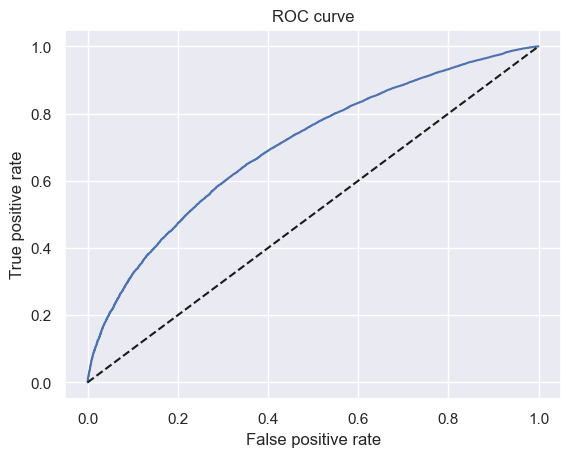

In [148]:
plt.plot(fpr, tpr)
# We plot the false positive rate along the x-axis and the true positive rate along the y-axis,
# thus plotting the ROC curve.
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
# We plot a seconary diagonal line, with dashed line style and black color.
plt.xlabel('False positive rate')
# We name the x-axis "False positive rate".
plt.ylabel('True positive rate')
# We name the x-axis "True positive rate".
plt.title('ROC curve')
# We name the graph "ROC curve".

In [151]:
AUROC = roc_auc_score(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])
# Calculates the Area Under the Receiver Operating Characteristic Curve (AUROC)
# from a set of actual values and their predicted probabilities.
AUROC

# Each point from the ROC curve represents a confusion matrix
## A ROC curve is a plot of the true positive rate (Sensitivity) in function of the false positive rate (100-Specificity) for different cut-off points of a parameter. Each point on the ROC curve represents a sensitivity/specificity pair corresponding to a particular decision threshold.

0.7017789162307977

### Gini and Kolmogorov-Smirnov

In [154]:
df_actual_predicted_probs = df_actual_predicted_probs.sort_values('y_hat_test_proba')
# Sorts a dataframe by the values of a specific column.

In [156]:
df_actual_predicted_probs.head()

,loan_data_targets_test,y_hat_test_proba,y_hat_test
11208,0,0.494817,0
118702,1,0.495139,0
41663,1,0.499606,0
210472,0,0.505942,0
2808,0,0.507809,0


In [158]:
df_actual_predicted_probs.tail()

,loan_data_targets_test,y_hat_test_proba,y_hat_test
261095,0,0.990635,1
231463,1,0.991017,1
239228,1,0.991254,1
261086,1,0.992052,1
242624,1,0.992566,1


In [160]:
df_actual_predicted_probs = df_actual_predicted_probs.reset_index()
# We reset the index of a dataframe and overwrite it.

In [162]:
df_actual_predicted_probs.head()

,index,loan_data_targets_test,y_hat_test_proba,y_hat_test
0,11208,0,0.494817,0
1,118702,1,0.495139,0
2,41663,1,0.499606,0
3,210472,0,0.505942,0
4,2808,0,0.507809,0


In [164]:
df_actual_predicted_probs['Cumulative N Population'] = df_actual_predicted_probs.index + 1
# We calculate the cumulative number of all observations.
# We use the new index for that. Since indexing in ython starts from 0, we add 1 to each index.
df_actual_predicted_probs['Cumulative N Good'] = df_actual_predicted_probs['loan_data_targets_test'].cumsum()
# We calculate cumulative number of 'good', which is the cumulative sum of the column with actual observations.
df_actual_predicted_probs['Cumulative N Bad'] = df_actual_predicted_probs['Cumulative N Population'] - df_actual_predicted_probs['loan_data_targets_test'].cumsum()
# We calculate cumulative number of 'bad', which is
# the difference between the cumulative number of all observations and cumulative number of 'good' for each row.

In [166]:
df_actual_predicted_probs.head()

,index,loan_data_targets_test,y_hat_test_proba,y_hat_test,Cumulative N Population,Cumulative N Good,Cumulative N Bad
0,11208,0,0.494817,0,1,0,1
1,118702,1,0.495139,0,2,1,1
2,41663,1,0.499606,0,3,2,1
3,210472,0,0.505942,0,4,2,2
4,2808,0,0.507809,0,5,2,3


In [168]:
df_actual_predicted_probs['Cumulative Perc Population'] = df_actual_predicted_probs['Cumulative N Population'] / (df_actual_predicted_probs.shape[0])
# the cumulative proportion of all borrowers on every row is the total number of borrowers up to that row divided by the total number of borrower altogether
# We calculate the cumulative percentage of all observations.

df_actual_predicted_probs['Cumulative Perc Good'] = df_actual_predicted_probs['Cumulative N Good'] / df_actual_predicted_probs['loan_data_targets_test'].sum()
# the cumulative proportion of good borrower is equal to the good borrower on each row divided by the total number of  borrower altogether
# We calculate cumulative percentage of 'good'.

df_actual_predicted_probs['Cumulative Perc Bad'] = df_actual_predicted_probs['Cumulative N Bad'] / (df_actual_predicted_probs.shape[0] - df_actual_predicted_probs['loan_data_targets_test'].sum())
# the cumulative proportion of bad borrower is the total number of bad borrower on each row divided by the total number of borrower altogether
# We calculate the cumulative percentage of 'bad'.

In [170]:
df_actual_predicted_probs.head()

,index,loan_data_targets_test,y_hat_test_proba,y_hat_test,Cumulative N Population,Cumulative N Good,Cumulative N Bad,Cumulative Perc Population,Cumulative Perc Good,Cumulative Perc Bad
0,11208,0,0.494817,0,1,0,1,0.000011,0.000000,0.000098
1,118702,1,0.495139,0,2,1,1,0.000021,0.000012,0.000098
2,41663,1,0.499606,0,3,2,1,0.000032,0.000024,0.000098
3,210472,0,0.505942,0,4,2,2,0.000043,0.000024,0.000196
4,2808,0,0.507809,0,5,2,3,0.000054,0.000024,0.000294


In [172]:
df_actual_predicted_probs.tail()

,index,loan_data_targets_test,y_hat_test_proba,y_hat_test,Cumulative N Population,Cumulative N Good,Cumulative N Bad,Cumulative Perc Population,Cumulative Perc Good,Cumulative Perc Bad
93252,261095,0,0.990635,1,93253,83063,10190,0.999957,0.999952,1.0
93253,231463,1,0.991017,1,93254,83064,10190,0.999968,0.999964,1.0
93254,239228,1,0.991254,1,93255,83065,10190,0.999979,0.999976,1.0
93255,261086,1,0.992052,1,93256,83066,10190,0.999989,0.999988,1.0
93256,242624,1,0.992566,1,93257,83067,10190,1.000000,1.000000,1.0


Text(0.5, 1.0, 'Gini')

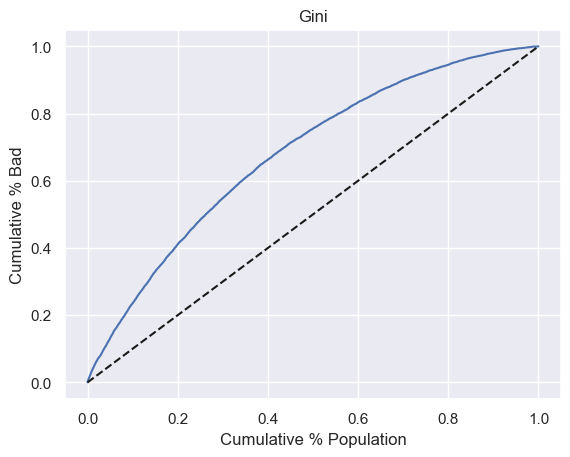

In [174]:
# Plot Gini
# Gini is a plot of a cumulative percentage of bad borrower as a function of the cumulative
# percentage of all borrower
## In the context of PD (probability of default), Gini curve shows the cumulative proportion 
## of defaulted borrowers as a function of the cumulative proportion of all borrowers

# we should plot the cumulative percentage of all borrower on the x - axis and the 
# cumulative percentage of bad borrower on y axis
plt.plot(df_actual_predicted_probs['Cumulative Perc Population'], df_actual_predicted_probs['Cumulative Perc Bad'])
# We plot the cumulative percentage of all along the x-axis and the cumulative percentage 'good' along the y-axis,
# thus plotting the Gini curve.
plt.plot(df_actual_predicted_probs['Cumulative Perc Population'], df_actual_predicted_probs['Cumulative Perc Population'], linestyle = '--', color = 'k')
# We plot a seconary diagonal line, with dashed line style and black color.
plt.xlabel('Cumulative % Population')
# We name the x-axis "Cumulative % Population".
plt.ylabel('Cumulative % Bad')
# We name the y-axis "Cumulative % Bad".
plt.title('Gini')
# We name the graph "Gini".

In [175]:
Gini = AUROC * 2 - 1
# Here we calculate Gini from AUROC.
Gini

## Note: the relationship between the Gini coefficient and the area under the receiver operating characteristic curve
## AUROC = (Gini + 1) / 2

0.4035578324615954

Text(0.5, 1.0, 'Kolmogorov-Smirnov')

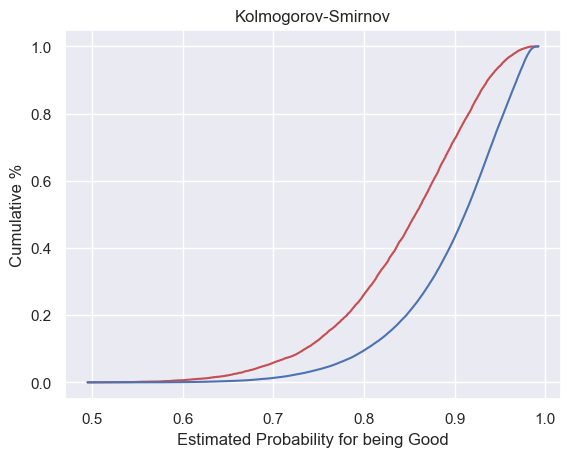

In [178]:
# Plot KS

## Note: to calculate Kolmogorov-Smirnov, we take:
## the maximum difference between the cumulative distribution function of bad borrowers and the cumulative distribution function of good borrowers
# KS measures the distance between two cumulative distribution functions, the further apart they are
# the better the underlying feature differentiate them

# if our model was perfect: it would estimate such probabilty of being a good borrower that it would set
# the 2 cumulative distribution as far from one another as possible (Maximum distance) 
# => the K-S statistic will be 1

# in the opposite case, if our model was as good as predicting by chance, the 2 cumulative distribution
# won't differ with respect to estimated probability of being a good borrower 
# => and K-S would be 0

plt.plot(df_actual_predicted_probs['y_hat_test_proba'], df_actual_predicted_probs['Cumulative Perc Bad'], color = 'r')
# We plot the predicted (estimated) probabilities along the x-axis and the cumulative percentage 'bad' along the y-axis,
# colored in red.
plt.plot(df_actual_predicted_probs['y_hat_test_proba'], df_actual_predicted_probs['Cumulative Perc Good'], color = 'b')
# We plot the predicted (estimated) probabilities along the x-axis and the cumulative percentage 'good' along the y-axis,
# colored in red.
plt.xlabel('Estimated Probability for being Good')
# We name the x-axis "Estimated Probability for being Good".
plt.ylabel('Cumulative %')
# We name the y-axis "Cumulative %".
plt.title('Kolmogorov-Smirnov')
# We name the graph "Kolmogorov-Smirnov".

### Note:  the two cumulative distribution functions are sufficiently far away from each other and the model
## has satisfactory predictive power.

In [179]:
KS = max(df_actual_predicted_probs['Cumulative Perc Bad'] - df_actual_predicted_probs['Cumulative Perc Good'])
# We calculate KS from the data. It is the maximum of the difference between the cumulative percentage of 'bad'
# and the cumulative percentage of 'good'.
KS

0.2968000044137137

# Applying the PD Model

## Calculating PD of individual accounts


In [184]:
pd.options.display.max_columns = None
# Sets the pandas dataframe options to display all columns/ rows.

In [186]:
inputs_test_with_ref_cat.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:RENT_OTHER_NONE_ANY,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:ND_NE_IA_NV_FL_HI_AL,addr_state:NM_VA,addr_state:NY,addr_state:OK_TN_MO_LA_MD_NC,addr_state:CA,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:TX,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:educ__sm_b__wedd__ren_en__mov__house,purpose:credit_card,purpose:debt_consolidation,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,initial_list_status:f,initial_list_status:w,term:36,term:60,emp_length:0,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,mths_since_issue_d:>84,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,int_rate:>20.281,mths_since_earliest_cr_line:<140,mths_since_earliest_cr_line:141-164,mths_since_earliest_cr_line:165-247,mths_since_earliest_cr_line:248-270,mths_since_earliest_cr_line:271-352,mths_since_earliest_cr_line:>352,inq_last_6mths:0,inq_last_6mths:1-2,inq_last_6mths:3-6,inq_last_6mths:>6,acc_now_delinq:0,acc_now_delinq:>=1,annual_inc:<20K,annual_inc:20K-30K,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_delinq:Missing,mths_since_last_delinq:0-3,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>=86
362514,False,False,True,False,False,False,False,0,False,True,0,0,False,0,True,0,0,0,0,0,False,0,0,0,False,False,True,0,False,False,0,1,True,False,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
288564,False,False,False,False,True,False,False,0,False,True,0,0,False,0,False,0,0,1,0,0,False,0,0,0,False,False,True,0,True,False,0,0,False,True,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
213591,False,False,True,False,False,False,False,0,False,True,0,0,False,0,False,1,0,0,0,0,False,0,0,0,False,False,True,0,False,True,0,0,True,False,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
263083,False,False,True,False,False,False,False,0,False,True,0,0,False,0,False,0,1,0,0,0,False,0,0,0,False,True,False,0,False,True,0,0,False,True,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
165001,True,False,False,False,False,False,False,0,False,True,0,0,False,0,False,0,1,0,0,0,False,0,0,0,False,False,True,0,False,True,0,0,True,False,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0


In [187]:
summary_table
# take the first observation from the dataset: index is 362514
# first take the coef of the intercept (-0.445985)
# then take the external grade of this obersvation C (coef: 0.549044), added the respective coef ( -0.445985 + 0.549044 = 0.103059)
# home ownership status: mortgage (0.103059 + 0.105095 = 0.208154)
# addr_state: CA (0.208154 + 0.073258 = 0.281412)
# the verification status is Verified but we have used it as a reference category hence we add 0
# we can continue adding until we added all the relatvent coefs
# purpose:major_purch__car__home_impr:0.281412 + 0.242110 = 0.523522
# mths_since_issue_d:40-41: 0.523522 + 0.844111 = 1.367633
# int_rate:12.025-15.74 : 1.367633 + 0.361330 = 1.728963
# mths_since_earliest_cr_line:165-247:  	1.728963 + 0.057176 = 1.786139
# inq_last_6mths:0:  	1.786139 + 0.271788 = 2.057927
# annual_inc:60K-70K: 2.057927 + 0.121916 = 2.179843
# dti:7.7-10.5:  	2.179843 + 0.136558 = 2.316401
# mths_since_last_delinq:Missing: 2.316401 + 0.082870 = 2.399271
# mths_since_last_record:Missing:  2.399271 + 0.102070 = 2.501341

# ln((1-PD) / PD ) = 2.501341
# get rid of log: ((1-PD) / PD ) = exp(2.501341)
# (1-PD) / PD  = 12.198842

# 1-PD = 12.198842 / (12.198842+1)
# 1-PD = 12.198842 / (13.198842)

# 1-PD = 0.9242358

# the probability of this person will not default is 92.42358%

,Feature name,Coefficients,p_values
0,Intercept,-0.445985,NaN
1,grade:A,0.944051,4.229369e-25
2,grade:B,0.732144,1.440979e-32
3,grade:C,0.549044,7.371959e-22
4,grade:D,0.373379,5.637468e-12
5,grade:E,0.219520,5.131963e-06
6,grade:F,0.049873,3.185217e-01
7,home_ownership:OWN,0.096256,1.835873e-06
8,home_ownership:MORTGAGE,0.105095,9.223599e-17
9,addr_state:NM_VA,0.044426,1.648468e-01


In [190]:
y_hat_test_proba

array([0.92423583, 0.85019704, 0.88515548, ..., 0.97307279, 0.95977633,
       0.95206567])

# Creating a Scorecard


In [193]:
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-0.445985,NaN
1,grade:A,0.944051,4.229369e-25
2,grade:B,0.732144,1.440979e-32
3,grade:C,0.549044,7.371959e-22
4,grade:D,0.373379,5.637468e-12
5,grade:E,0.219520,5.131963e-06
6,grade:F,0.049873,3.185217e-01
7,home_ownership:OWN,0.096256,1.835873e-06
8,home_ownership:MORTGAGE,0.105095,9.223599e-17
9,addr_state:NM_VA,0.044426,1.648468e-01


In [195]:
ref_categories

['grade:G',
 'home_ownership:RENT_OTHER_NONE_ANY',
 'addr_state:ND_NE_IA_NV_FL_HI_AL',
 'verification_status:Verified',
 'purpose:educ__sm_b__wedd__ren_en__mov__house',
 'initial_list_status:f',
 'term:60',
 'emp_length:0',
 'mths_since_issue_d:>84',
 'int_rate:>20.281',
 'mths_since_earliest_cr_line:<140',
 'inq_last_6mths:>6',
 'acc_now_delinq:0',
 'annual_inc:<20K',
 'dti:>35',
 'mths_since_last_delinq:0-3',
 'mths_since_last_record:0-2']

In [197]:
df_ref_categories = pd.DataFrame(ref_categories, columns = ['Feature name'])
# We create a new dataframe with one column. Its values are the values from the 'reference_categories' list.
# We name it 'Feature name'.
df_ref_categories['Coefficients'] = 0
# We create a second column, called 'Coefficients', which contains only 0 values.
df_ref_categories['p_values'] = np.nan
# We create a third column, called 'p_values', with contains only NaN values.
df_ref_categories

,Feature name,Coefficients,p_values
0,grade:G,0,NaN
1,home_ownership:RENT_OTHER_NONE_ANY,0,NaN
2,addr_state:ND_NE_IA_NV_FL_HI_AL,0,NaN
3,verification_status:Verified,0,NaN
4,purpose:educ__sm_b__wedd__ren_en__mov__house,0,NaN
5,initial_list_status:f,0,NaN
6,term:60,0,NaN
7,emp_length:0,0,NaN
8,mths_since_issue_d:>84,0,NaN
9,int_rate:>20.281,0,NaN


In [199]:
df_scorecard = pd.concat([summary_table, df_ref_categories])
# Concatenates two dataframes.
df_scorecard = df_scorecard.reset_index()
# We reset the index of a dataframe.
df_scorecard

# this way we will get the output from our PD model as if we had included the reference categories 
# in the model estimation and had coefficients of 0

,index,Feature name,Coefficients,p_values
0,0,Intercept,-0.445985,NaN
1,1,grade:A,0.944051,4.229369e-25
2,2,grade:B,0.732144,1.440979e-32
3,3,grade:C,0.549044,7.371959e-22
4,4,grade:D,0.373379,5.637468e-12
5,5,grade:E,0.219520,5.131963e-06
6,6,grade:F,0.049873,3.185217e-01
7,7,home_ownership:OWN,0.096256,1.835873e-06
8,8,home_ownership:MORTGAGE,0.105095,9.223599e-17
9,9,addr_state:NM_VA,0.044426,1.648468e-01


In [201]:
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]
# We create a new column, called 'Original feature name', which contains the value of the 'Feature name' column,
# up to the column symbol.
# df_scorecard

In [203]:
# in order to create a scorecard, we need to turn the regression 
# coefs from our PD model into simple scores

# first, we decide the minimum and maximum score
min_score = 300
max_score = 850

In [205]:
# we also need the minimum and the maximum of the credit worthiness 
# assessments that can be obtained from the PD model.

# the minimum credit assessment is reached when a borrower falls into the 'worst' categories
# for all variables

# the maximum credit assessment is reached when a borrower falls into the 'best' categories for all variables

df_scorecard.groupby('Original feature name')['Coefficients'].min()
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their minimum.

Original feature name
Intercept                     -0.445985
acc_now_delinq                 0.000000
addr_state                     0.000000
annual_inc                    -0.179924
dti                           -0.137457
emp_length                     0.000000
grade                          0.000000
home_ownership                 0.000000
initial_list_status            0.000000
inq_last_6mths                -0.080300
int_rate                       0.000000
mths_since_earliest_cr_line    0.000000
mths_since_issue_d            -0.007180
mths_since_last_delinq         0.000000
mths_since_last_record        -0.091750
purpose                        0.000000
term                           0.000000
verification_status           -0.013063
Name: Coefficients, dtype: float64

In [207]:
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
# Up to the 'min()' method everything is the same as in te line above.
# Then, we aggregate further and sum all the minimum values.
min_sum_coef

-0.9556596161363737

In [209]:

df_scorecard.groupby('Original feature name')['Coefficients'].max()
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their maximum.

Original feature name
Intercept                     -0.445985
acc_now_delinq                 0.147718
addr_state                     0.500647
annual_inc                     0.482019
dti                            0.203104
emp_length                     0.133383
grade                          0.944051
home_ownership                 0.105095
initial_list_status            0.049503
inq_last_6mths                 0.271788
int_rate                       0.964427
mths_since_earliest_cr_line    0.152760
mths_since_issue_d             1.133686
mths_since_last_delinq         0.150261
mths_since_last_record         0.276375
purpose                        0.283008
term                           0.080814
verification_status            0.080358
Name: Coefficients, dtype: float64

In [211]:
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
# Up to the 'min()' method everything is the same as in te line above.
# Then, we aggregate further and sum all the maximum values.
max_sum_coef

5.513010997808484

In [213]:
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
# We multiply the value of the 'Coefficients' column by the ration of the differences between
# maximum score and minimum score and maximum sum of coefficients and minimum sum of cefficients.
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation
0,0,Intercept,-0.445985,NaN,Intercept,-37.919935
1,1,grade:A,0.944051,4.229369e-25,grade,80.268148
2,2,grade:B,0.732144,1.440979e-32,grade,62.250667
3,3,grade:C,0.549044,7.371959e-22,grade,46.682562
4,4,grade:D,0.373379,5.637468e-12,grade,31.746632
5,5,grade:E,0.219520,5.131963e-06,grade,18.664748
6,6,grade:F,0.049873,3.185217e-01,grade,4.240478
7,7,home_ownership:OWN,0.096256,1.835873e-06,home_ownership,8.184147
8,8,home_ownership:MORTGAGE,0.105095,9.223599e-17,home_ownership,8.935715
9,9,addr_state:NM_VA,0.044426,1.648468e-01,addr_state,3.777342


In [221]:
df_scorecard['Score - Calculation'][0] = ((df_scorecard['Coefficients'][0] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score

# We divide the difference of the value of the 'Coefficients' column and the minimum sum of coefficients by
# the difference of the maximum sum of coefficients and the minimum sum of coefficients.
# Then, we multiply that by the difference between the maximum score and the minimum score.
# Then, we add minimum score. 
df_scorecard

C:\Users\Adali\AppData\Local\Temp\ipykernel_23696\237288230.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_scorecard['Score - Calculation'][0] = ((df_scorecard['Coefficients'][0] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (ma

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation
0,0,Intercept,-0.445985,NaN,Intercept,343.335213
1,1,grade:A,0.944051,4.229369e-25,grade,80.268148
2,2,grade:B,0.732144,1.440979e-32,grade,62.250667
3,3,grade:C,0.549044,7.371959e-22,grade,46.682562
4,4,grade:D,0.373379,5.637468e-12,grade,31.746632
5,5,grade:E,0.219520,5.131963e-06,grade,18.664748
6,6,grade:F,0.049873,3.185217e-01,grade,4.240478
7,7,home_ownership:OWN,0.096256,1.835873e-06,home_ownership,8.184147
8,8,home_ownership:MORTGAGE,0.105095,9.223599e-17,home_ownership,8.935715
9,9,addr_state:NM_VA,0.044426,1.648468e-01,addr_state,3.777342


In [223]:
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
# We round the values of the 'Score - Calculation' column.
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary
0,0,Intercept,-0.445985,NaN,Intercept,343.335213,343.0
1,1,grade:A,0.944051,4.229369e-25,grade,80.268148,80.0
2,2,grade:B,0.732144,1.440979e-32,grade,62.250667,62.0
3,3,grade:C,0.549044,7.371959e-22,grade,46.682562,47.0
4,4,grade:D,0.373379,5.637468e-12,grade,31.746632,32.0
5,5,grade:E,0.219520,5.131963e-06,grade,18.664748,19.0
6,6,grade:F,0.049873,3.185217e-01,grade,4.240478,4.0
7,7,home_ownership:OWN,0.096256,1.835873e-06,home_ownership,8.184147,8.0
8,8,home_ownership:MORTGAGE,0.105095,9.223599e-17,home_ownership,8.935715,9.0
9,9,addr_state:NM_VA,0.044426,1.648468e-01,addr_state,3.777342,4.0


In [225]:
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their minimum.
# Sums all minimum values.
min_sum_score_prel

299.0

In [227]:
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their maximum.
# Sums all maximum values.
max_sum_score_prel

849.0

In [229]:
# One has to be subtracted from the maximum score for one original variable. Which one? We'll evaluate based on differences.

In [231]:
df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary,Difference
0,0,Intercept,-0.445985,NaN,Intercept,343.335213,343.0,-0.335213
1,1,grade:A,0.944051,4.229369e-25,grade,80.268148,80.0,-0.268148
2,2,grade:B,0.732144,1.440979e-32,grade,62.250667,62.0,-0.250667
3,3,grade:C,0.549044,7.371959e-22,grade,46.682562,47.0,0.317438
4,4,grade:D,0.373379,5.637468e-12,grade,31.746632,32.0,0.253368
5,5,grade:E,0.219520,5.131963e-06,grade,18.664748,19.0,0.335252
6,6,grade:F,0.049873,3.185217e-01,grade,4.240478,4.0,-0.240478
7,7,home_ownership:OWN,0.096256,1.835873e-06,home_ownership,8.184147,8.0,-0.184147
8,8,home_ownership:MORTGAGE,0.105095,9.223599e-17,home_ownership,8.935715,9.0,0.064285
9,9,addr_state:NM_VA,0.044426,1.648468e-01,addr_state,3.777342,4.0,0.222658


In [233]:
# Step 1: Set 'Score - Final' equal to 'Score - Preliminary'
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard.loc[82, 'Score - Final'] = 24
# Step 2: Recalculate the max and min scores
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].max().sum()
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].min().sum()

# Step 3: Adjust the max score to 850
if max_sum_score_prel > 850:
    # Identify rows with the highest 'Score - Final' and reduce them
    while max_sum_score_prel > 850:
        # Find the row with the highest score to reduce
        row_to_reduce = df_scorecard['Score - Final'].idxmax()
        df_scorecard.loc[row_to_reduce, 'Score - Final'] -= 1
        # Recalculate the max sum
        max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].max().sum()

# Step 4: Adjust the min score to 300
if min_sum_score_prel < 300:
    # Identify rows with the lowest 'Score - Final' and increase them
    while min_sum_score_prel < 300:
        # Find the row with the smallest score to increase
        row_to_increase = df_scorecard['Score - Final'].idxmin()
        df_scorecard.loc[row_to_increase, 'Score - Final'] += 1
        # Recalculate the min sum
        min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].min().sum()

# Output the updated DataFrame and the new minimum and maximum score sums
df_scorecard

#min_sum_score_prel, max_sum_score_prel


,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,0,Intercept,-0.445985,NaN,Intercept,343.335213,343.0,-0.335213,343.0
1,1,grade:A,0.944051,4.229369e-25,grade,80.268148,80.0,-0.268148,80.0
2,2,grade:B,0.732144,1.440979e-32,grade,62.250667,62.0,-0.250667,62.0
3,3,grade:C,0.549044,7.371959e-22,grade,46.682562,47.0,0.317438,47.0
4,4,grade:D,0.373379,5.637468e-12,grade,31.746632,32.0,0.253368,32.0
5,5,grade:E,0.219520,5.131963e-06,grade,18.664748,19.0,0.335252,19.0
6,6,grade:F,0.049873,3.185217e-01,grade,4.240478,4.0,-0.240478,4.0
7,7,home_ownership:OWN,0.096256,1.835873e-06,home_ownership,8.184147,8.0,-0.184147,8.0
8,8,home_ownership:MORTGAGE,0.105095,9.223599e-17,home_ownership,8.935715,9.0,0.064285,9.0
9,9,addr_state:NM_VA,0.044426,1.648468e-01,addr_state,3.777342,4.0,0.222658,4.0


In [235]:
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,0,Intercept,-0.445985,NaN,Intercept,343.335213,343.0,-0.335213,343.0
1,1,grade:A,0.944051,4.229369e-25,grade,80.268148,80.0,-0.268148,80.0
2,2,grade:B,0.732144,1.440979e-32,grade,62.250667,62.0,-0.250667,62.0
3,3,grade:C,0.549044,7.371959e-22,grade,46.682562,47.0,0.317438,47.0
4,4,grade:D,0.373379,5.637468e-12,grade,31.746632,32.0,0.253368,32.0
5,5,grade:E,0.219520,5.131963e-06,grade,18.664748,19.0,0.335252,19.0
6,6,grade:F,0.049873,3.185217e-01,grade,4.240478,4.0,-0.240478,4.0
7,7,home_ownership:OWN,0.096256,1.835873e-06,home_ownership,8.184147,8.0,-0.184147,8.0
8,8,home_ownership:MORTGAGE,0.105095,9.223599e-17,home_ownership,8.935715,9.0,0.064285,9.0
9,9,addr_state:NM_VA,0.044426,1.648468e-01,addr_state,3.777342,4.0,0.222658,4.0


In [236]:
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].min().sum()
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their minimum.
# Sums all minimum values.
min_sum_score_prel

300.0

In [239]:
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].max().sum()
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their maximum.
# Sums all maximum values.
max_sum_score_prel

850.0

# Caclulating Credit Score

In [242]:
inputs_test_with_ref_cat.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:RENT_OTHER_NONE_ANY,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:ND_NE_IA_NV_FL_HI_AL,addr_state:NM_VA,addr_state:NY,addr_state:OK_TN_MO_LA_MD_NC,addr_state:CA,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:TX,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:educ__sm_b__wedd__ren_en__mov__house,purpose:credit_card,purpose:debt_consolidation,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,initial_list_status:f,initial_list_status:w,term:36,term:60,emp_length:0,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,mths_since_issue_d:>84,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,int_rate:>20.281,mths_since_earliest_cr_line:<140,mths_since_earliest_cr_line:141-164,mths_since_earliest_cr_line:165-247,mths_since_earliest_cr_line:248-270,mths_since_earliest_cr_line:271-352,mths_since_earliest_cr_line:>352,inq_last_6mths:0,inq_last_6mths:1-2,inq_last_6mths:3-6,inq_last_6mths:>6,acc_now_delinq:0,acc_now_delinq:>=1,annual_inc:<20K,annual_inc:20K-30K,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_delinq:Missing,mths_since_last_delinq:0-3,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>=86
362514,False,False,True,False,False,False,False,0,False,True,0,0,False,0,True,0,0,0,0,0,False,0,0,0,False,False,True,0,False,False,0,1,True,False,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
288564,False,False,False,False,True,False,False,0,False,True,0,0,False,0,False,0,0,1,0,0,False,0,0,0,False,False,True,0,True,False,0,0,False,True,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
213591,False,False,True,False,False,False,False,0,False,True,0,0,False,0,False,1,0,0,0,0,False,0,0,0,False,False,True,0,False,True,0,0,True,False,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
263083,False,False,True,False,False,False,False,0,False,True,0,0,False,0,False,0,1,0,0,0,False,0,0,0,False,True,False,0,False,True,0,0,False,True,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
165001,True,False,False,False,False,False,False,0,False,True,0,0,False,0,False,0,1,0,0,0,False,0,0,0,False,False,True,0,False,True,0,0,True,False,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0


In [244]:
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,0,Intercept,-0.445985,NaN,Intercept,343.335213,343.0,-0.335213,343.0
1,1,grade:A,0.944051,4.229369e-25,grade,80.268148,80.0,-0.268148,80.0
2,2,grade:B,0.732144,1.440979e-32,grade,62.250667,62.0,-0.250667,62.0
3,3,grade:C,0.549044,7.371959e-22,grade,46.682562,47.0,0.317438,47.0
4,4,grade:D,0.373379,5.637468e-12,grade,31.746632,32.0,0.253368,32.0
5,5,grade:E,0.219520,5.131963e-06,grade,18.664748,19.0,0.335252,19.0
6,6,grade:F,0.049873,3.185217e-01,grade,4.240478,4.0,-0.240478,4.0
7,7,home_ownership:OWN,0.096256,1.835873e-06,home_ownership,8.184147,8.0,-0.184147,8.0
8,8,home_ownership:MORTGAGE,0.105095,9.223599e-17,home_ownership,8.935715,9.0,0.064285,9.0
9,9,addr_state:NM_VA,0.044426,1.648468e-01,addr_state,3.777342,4.0,0.222658,4.0


In [246]:
inputs_test_with_ref_cat_w_intercept = inputs_test_with_ref_cat

In [248]:
inputs_test_with_ref_cat_w_intercept.insert(0, 'Intercept', 1)
# We insert a column in the dataframe, with an index of 0, that is, in the beginning of the dataframe.
# The name of that column is 'Intercept', and its values are 1s.

In [250]:
inputs_test_with_ref_cat_w_intercept.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:RENT_OTHER_NONE_ANY,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:ND_NE_IA_NV_FL_HI_AL,addr_state:NM_VA,addr_state:NY,addr_state:OK_TN_MO_LA_MD_NC,addr_state:CA,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:TX,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:educ__sm_b__wedd__ren_en__mov__house,purpose:credit_card,purpose:debt_consolidation,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,initial_list_status:f,initial_list_status:w,term:36,term:60,emp_length:0,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,mths_since_issue_d:>84,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,int_rate:>20.281,mths_since_earliest_cr_line:<140,mths_since_earliest_cr_line:141-164,mths_since_earliest_cr_line:165-247,mths_since_earliest_cr_line:248-270,mths_since_earliest_cr_line:271-352,mths_since_earliest_cr_line:>352,inq_last_6mths:0,inq_last_6mths:1-2,inq_last_6mths:3-6,inq_last_6mths:>6,acc_now_delinq:0,acc_now_delinq:>=1,annual_inc:<20K,annual_inc:20K-30K,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_delinq:Missing,mths_since_last_delinq:0-3,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>=86
362514,1,False,False,True,False,False,False,False,0,False,True,0,0,False,0,True,0,0,0,0,0,False,0,0,0,False,False,True,0,False,False,0,1,True,False,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
288564,1,False,False,False,False,True,False,False,0,False,True,0,0,False,0,False,0,0,1,0,0,False,0,0,0,False,False,True,0,True,False,0,0,False,True,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
213591,1,False,False,True,False,False,False,False,0,False,True,0,0,False,0,False,1,0,0,0,0,False,0,0,0,False,False,True,0,False,True,0,0,True,False,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
263083,1,False,False,True,False,False,False,False,0,False,True,0,0,False,0,False,0,1,0,0,0,False,0,0,0,False,True,False,0,False,True,0,0,False,True,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
165001,1,True,False,False,False,False,False,False,0,False,True,0,0,False,0,False,0,1,0,0,0,False,0,0,0,False,False,True,0,False,True,0,0,True,False,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0


In [252]:
inputs_test_with_ref_cat_w_intercept = inputs_test_with_ref_cat_w_intercept[df_scorecard['Feature name'].values]
# Here, from the 'inputs_test_with_ref_cat_w_intercept' dataframe, we keep only the columns with column names,
# exactly equal to the row values of the 'Feature name' column from the 'df_scorecard' dataframe.

In [254]:
inputs_test_with_ref_cat_w_intercept.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,addr_state:OK_TN_MO_LA_MD_NC,addr_state:CA,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:TX,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,verification_status:Not Verified,verification_status:Source Verified,purpose:credit_card,purpose:debt_consolidation,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,initial_list_status:w,term:36,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,mths_since_earliest_cr_line:141-164,mths_since_earliest_cr_line:165-247,mths_since_earliest_cr_line:248-270,mths_since_earliest_cr_line:271-352,mths_since_earliest_cr_line:>352,inq_last_6mths:0,inq_last_6mths:1-2,inq_last_6mths:3-6,acc_now_delinq:>=1,annual_inc:20K-30K,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>=86,grade:G,home_ownership:RENT_OTHER_NONE_ANY,addr_state:ND_NE_IA_NV_FL_HI_AL,verification_status:Verified,purpose:educ__sm_b__wedd__ren_en__mov__house,initial_list_status:f,term:60,emp_length:0,mths_since_issue_d:>84,int_rate:>20.281,mths_since_earliest_cr_line:<140,inq_last_6mths:>6,acc_now_delinq:0,annual_inc:<20K,dti:>35,mths_since_last_delinq:0-3,mths_since_last_record:0-2
362514,1,False,False,True,False,False,False,False,True,0,False,0,True,0,0,0,0,0,False,0,0,0,False,False,False,False,0,1,False,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,False,0,0,True,0,True,1,1,0,0,0,0,1,0,0,0,0
288564,1,False,False,False,False,True,False,False,True,0,False,0,False,0,0,1,0,0,False,0,0,0,False,False,True,False,0,0,True,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,False,0,0,True,0,False,1,0,0,1,0,0,1,0,0,1,0
213591,1,False,False,True,False,False,False,False,True,0,False,0,False,1,0,0,0,0,False,0,0,0,False,False,False,True,0,0,False,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,False,0,0,True,0,True,0,0,0,0,0,0,1,0,0,0,0
263083,1,False,False,True,False,False,False,False,True,0,False,0,False,0,1,0,0,0,False,0,0,0,False,True,False,True,0,0,True,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,False,0,0,False,0,False,1,0,0,0,1,0,1,0,0,0,0
165001,1,True,False,False,False,False,False,False,True,0,False,0,False,0,1,0,0,0,False,0,0,0,False,False,False,True,0,0,False,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,False,0,0,True,0,True,0,0,0,0,0,0,1,0,0,0,0


In [256]:
scorecard_scores = df_scorecard['Score - Final']

In [258]:
inputs_test_with_ref_cat_w_intercept.shape

(93257, 102)

In [260]:
scorecard_scores.shape

(102,)

In [262]:
scorecard_scores = scorecard_scores.values.reshape(102, 1)

In [264]:
scorecard_scores.shape

(102, 1)

In [266]:
y_scores = inputs_test_with_ref_cat_w_intercept.dot(scorecard_scores)
# Here we multiply the values of each row of the dataframe by the values of each column of the variable,
# which is an argument of the 'dot' method, and sum them. It's essentially the sum of the products.

In [267]:
y_scores.head()

,0
362514,595.0
288564,529.0
213591,556.0
263083,612.0
165001,673.0


In [269]:
y_scores.tail()

,0
115,551.0
296284,665.0
61777,687.0
91763,652.0
167512,635.0


# From Credit Score to PD

In [273]:
import numpy as np
import pandas as pd

In [277]:
sum_coef_from_score = ((y_scores - min_score) / (max_score - min_score)) * (max_sum_coef - min_sum_coef) + min_sum_coef
# We divide the difference between the scores and the minimum score by
# the difference between the maximum score and the minimum score.
# Then, we multiply that by the difference between the maximum sum of coefficients and the minimum sum of coefficients.
# Then, we add the minimum sum of coefficients.

In [291]:
# Check if sum_coef_from_score is a DataFrame and extract the first column if necessary
if isinstance(sum_coef_from_score, pd.DataFrame):
    sum_coef_from_score = sum_coef_from_score.iloc[:, 0]  # Select the first column if it's a DataFrame
# Check the type of sum_coef_from_score and print the first few rows
print(f"Data type of sum_coef_from_score: {type(sum_coef_from_score)}")
print("First few entries of sum_coef_from_score:")
print(sum_coef_from_score[:5])  # Use slicing for the first few entries

# Ensure sum_coef_from_score is a 1D array or Series
if not isinstance(sum_coef_from_score, (pd.Series, np.ndarray, list)):
    raise ValueError("sum_coef_from_score must be a list, tuple, 1D NumPy array, or Series.")

# Convert to a NumPy array if it's a Series or list
if isinstance(sum_coef_from_score, (pd.Series, list)):
    sum_coef_from_score = np.array(sum_coef_from_score)

# Ensure the values are numeric
try:
    sum_coef_from_score = sum_coef_from_score.astype(float)
except ValueError as e:
    print(f"Error converting sum_coef_from_score to float: {e}")
    raise

# Apply the logistic function (make sure values are numeric)
y_hat_proba_from_score = np.exp(sum_coef_from_score) / (np.exp(sum_coef_from_score) + 1)

# Check the result using slicing instead of .head()
print("First few probabilities from logistic transformation:")
print(y_hat_proba_from_score[:5])  # Display the first 5 results

# Compare the output with y_hat_test_proba and df_actual_predicted_probs
print("First few rows of y_hat_test_proba:")
print(y_hat_test_proba[:5])

print("First few rows from df_actual_predicted_probs:")
print(df_actual_predicted_probs['y_hat_test_proba'].head())

# Check the shapes of the arrays to ensure alignment
print(f"Shape of sum_coef_from_score: {sum_coef_from_score.shape}")
print(f"Shape of y_hat_proba_from_score: {y_hat_proba_from_score.shape}")

# the way we created our scorecard, to obtain an estimate for the PD of an applicant, using score, we have to:
# raise an exponent to the power of total score and divide that by the same thing plus one

Data type of sum_coef_from_score: <class 'numpy.ndarray'>
First few entries of sum_coef_from_score:
[2.51390008 1.7376596  2.05521252 2.7138408  3.43127518]
First few probabilities from logistic transformation:
[0.92511054 0.85038955 0.88647326 0.93783843 0.96866779]
First few rows of y_hat_test_proba:
[0.92423583 0.85019704 0.88515548 0.93872185 0.96857818]
First few rows from df_actual_predicted_probs:
0    0.494817
1    0.495139
2    0.499606
3    0.505942
4    0.507809
Name: y_hat_test_proba, dtype: float64
Shape of sum_coef_from_score: (93257,)
Shape of y_hat_proba_from_score: (93257,)


In [293]:
sum_coef_from_score.shape

(93257,)

In [295]:
type(sum_coef_from_score)

numpy.ndarray

In [303]:
#y_hat_proba_from_score = np.exp(sum_coef_from_score) / (np.exp(sum_coef_from_score) + 1)
# Here we divide an exponent raised to sum of coefficients from score by
# an exponent raised to sum of coefficients from score plus one.
#y_hat_proba_from_score.head()

In [305]:
y_hat_test_proba[0: 5]

array([0.92423583, 0.85019704, 0.88515548, 0.93872185, 0.96857818])

In [307]:
df_actual_predicted_probs['y_hat_test_proba'].head()

0    0.494817
1    0.495139
2    0.499606
3    0.505942
4    0.507809
Name: y_hat_test_proba, dtype: float64

In [ ]:
# Cut off rate: used for taking a decision whether to approve a loan application or not

# Setting Cut-offs

In [309]:
# we will use a more conservative treshold i.e. 0.9
tr = 0.9
#(under a treshold of tr =0.5, the model generates a lot of false positives, which means a lot of bad applicants / bad borrowers will be given loan
# We create a new column with an indicator,
# where every observation that has predicted probability greater than the threshold has a value of 1,
# and every observation that has predicted probability lower than the threshold has a value of 0.
# Estimated probability <= cut-off probability: Bad (Default);
# Estimated probability > cut-off probability: Good (Non-Default);
df_actual_predicted_probs['y_hat_test'] = np.where(df_actual_predicted_probs['y_hat_test_proba'] > tr, 1, 0)

In [311]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted'])
# Creates a cross-table where the actual values are displayed by rows and the predicted values by columns.
# This table is known as a Confusion Matrix.

# overall accuracy is not the universal measure for a PD model, the rate of the true positive prediction: Good that are being correctly classified as good and the false positive prediction: Bad that is incorrectly classified as good are far more important than the overall accuracy

Predicted,0,1
Actual,,
0,7383,2807
1,35819,47248


In [313]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]
# Here we divide each value of the table by the total number of observations,
# thus getting percentages, or, rates.

Predicted,0,1
Actual,,
0,0.079168,0.030100
1,0.384089,0.506643


In [315]:
(pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'],
             rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[0, 0] + (pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], 
             rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[1, 1]
# Here we calculate Accuracy of the model, which is the sum of the diagonal rates.

# the overall accuracy seems to be much lower than the result from tr = 0.5

0.5858112527745907

In [317]:
from sklearn.metrics import roc_curve, roc_auc_score

In [319]:
roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])
# Returns the Receiver Operating Characteristic (ROC) Curve from a set of actual values and their predicted probabilities.
# As a result, we get three arrays: the false positive rates, the true positive rates, and the thresholds.

(array([0.        , 0.        , 0.        , ..., 0.99990186, 0.99990186,
        1.        ]),
 array([0.00000000e+00, 1.20384750e-05, 4.81538999e-05, ...,
        9.99975923e-01, 1.00000000e+00, 1.00000000e+00]),
 array([       inf, 0.99256562, 0.99101667, ..., 0.50594177, 0.49513903,
        0.49481669]))

In [321]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])
# Here we store each of the three arrays in a separate variable. 

In [323]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Text(0.5, 1.0, 'ROC curve')

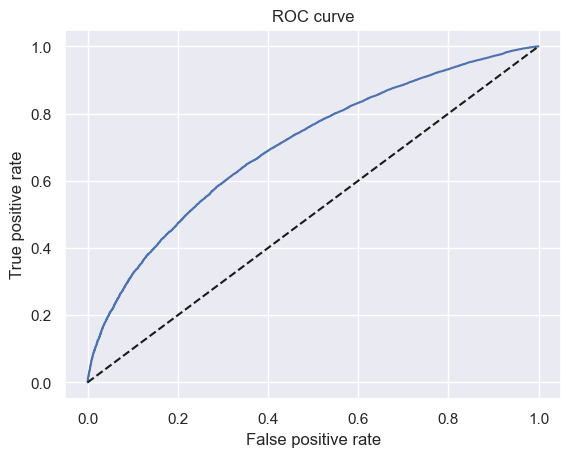

In [325]:
plt.plot(fpr, tpr)
# We plot the false positive rate along the x-axis and the true positive rate along the y-axis,
# thus plotting the ROC curve.
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
# We plot a seconary diagonal line, with dashed line style and black color.
plt.xlabel('False positive rate')
# We name the x-axis "False positive rate".
plt.ylabel('True positive rate')
# We name the x-axis "True positive rate".
plt.title('ROC curve')
# We name the graph "ROC curve".

In [327]:
thresholds

array([       inf, 0.99256562, 0.99101667, ..., 0.50594177, 0.49513903,
       0.49481669])

In [329]:
thresholds.shape

(17444,)

In [331]:
df_cutoffs = pd.concat([pd.DataFrame(thresholds), pd.DataFrame(fpr), pd.DataFrame(tpr)], axis = 1)
# We concatenate 3 dataframes along the columns.

In [333]:
df_cutoffs.columns = ['thresholds', 'fpr', 'tpr']
# We name the columns of the dataframe 'thresholds', 'fpr', and 'tpr'.

In [335]:
df_cutoffs.head()

,thresholds,fpr,tpr
0,inf,0.000000,0.000000
1,0.992566,0.000000,0.000012
2,0.991017,0.000000,0.000048
3,0.990635,0.000098,0.000048
4,0.989188,0.000098,0.000554


In [337]:
df_cutoffs['thresholds'][0] = 1 - 1 / np.power(10, 16)
# Let the first threshold (the value of the thresholds column with index 0) be equal to a number, very close to 1
# but smaller than 1, say 1 - 1 / 10 ^ 16.

C:\Users\Adali\AppData\Local\Temp\ipykernel_23696\2460372339.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_cutoffs['thresholds'][0] = 1 - 1 / np.power(10, 16)


In [339]:
df_cutoffs.head()

,thresholds,fpr,tpr
0,1.000000,0.000000,0.000000
1,0.992566,0.000000,0.000012
2,0.991017,0.000000,0.000048
3,0.990635,0.000098,0.000048
4,0.989188,0.000098,0.000554


In [341]:
df_cutoffs['Score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) * ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()
# The score corresponsing to each threshold equals:
# The the difference between the natural logarithm of the ratio of the threshold and 1 minus the threshold and
# the minimum sum of coefficients
# multiplied by
# the sum of the minimum score and the ratio of the difference between the maximum score and minimum score and 
# the difference between the maximum sum of coefficients and the minimum sum of coefficients.

In [343]:
df_cutoffs.head()

,thresholds,fpr,tpr,Score
0,1.000000,0.000000,0.000000,2197.0
1,0.992566,0.000000,0.000012,797.0
2,0.991017,0.000000,0.000048,781.0
3,0.990635,0.000098,0.000048,778.0
4,0.989188,0.000098,0.000554,765.0


In [345]:
df_cutoffs['Score'][0] = max_score

C:\Users\Adali\AppData\Local\Temp\ipykernel_23696\3137964156.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_cutoffs['Score'][0] = max_score


In [347]:
df_cutoffs.head()

,thresholds,fpr,tpr,Score
0,1.000000,0.000000,0.000000,850.0
1,0.992566,0.000000,0.000012,797.0
2,0.991017,0.000000,0.000048,781.0
3,0.990635,0.000098,0.000048,778.0
4,0.989188,0.000098,0.000554,765.0


In [349]:
df_cutoffs.tail()

,thresholds,fpr,tpr,Score
17439,0.527945,0.999509,0.999940,391.0
17440,0.525426,0.999509,0.999976,390.0
17441,0.505942,0.999902,0.999976,383.0
17442,0.495139,0.999902,1.000000,380.0
17443,0.494817,1.000000,1.000000,379.0


In [351]:
# We define a function called 'n_approved' which assigns a value of 1 if a predicted probability
# is greater than the parameter p, which is a threshold, and a value of 0, if it is not.
# Then it sums the column.
# Thus, if given any percentage values, the function will return
# the number of rows wih estimated probabilites greater than the threshold. 
def n_approved(p):
    return np.where(df_actual_predicted_probs['y_hat_test_proba'] >= p, 1, 0).sum()

In [353]:
df_cutoffs['N Approved'] = df_cutoffs['thresholds'].apply(n_approved)
# Assuming that all credit applications above a given probability of being 'good' will be approved,
# when we apply the 'n_approved' function to a threshold, it will return the number of approved applications.
# Thus, here we calculate the number of approved appliations for al thresholds.
df_cutoffs['N Rejected'] = df_actual_predicted_probs['y_hat_test_proba'].shape[0] - df_cutoffs['N Approved']
# Then, we calculate the number of rejected applications for each threshold.
# It is the difference between the total number of applications and the approved applications for that threshold.
df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / df_actual_predicted_probs['y_hat_test_proba'].shape[0]
# Approval rate equalts the ratio of the approved applications and all applications.
df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']
# Rejection rate equals one minus approval rate.

In [354]:
df_cutoffs.head()

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
0,1.000000,0.000000,0.000000,850.0,0,93257,0.000000,1.000000
1,0.992566,0.000000,0.000012,797.0,1,93256,0.000011,0.999989
2,0.991017,0.000000,0.000048,781.0,4,93253,0.000043,0.999957
3,0.990635,0.000098,0.000048,778.0,5,93252,0.000054,0.999946
4,0.989188,0.000098,0.000554,765.0,47,93210,0.000504,0.999496


In [355]:
df_cutoffs.tail()

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
17439,0.527945,0.999509,0.999940,391.0,93247,10,0.999893,0.000107
17440,0.525426,0.999509,0.999976,390.0,93250,7,0.999925,0.000075
17441,0.505942,0.999902,0.999976,383.0,93254,3,0.999968,0.000032
17442,0.495139,0.999902,1.000000,380.0,93256,1,0.999989,0.000011
17443,0.494817,1.000000,1.000000,379.0,93257,0,1.000000,0.000000


In [359]:
df_cutoffs.iloc[5000: 6200, ]
# Here we display the dataframe with cutoffs form line with index 5000 to line with index 6200.

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
5000,0.903687,0.258292,0.547052,572.0,48074,45183,0.515500,0.484500
5001,0.903686,0.258391,0.547052,572.0,48075,45182,0.515511,0.484489
5002,0.903684,0.258391,0.547088,572.0,48078,45179,0.515543,0.484457
5003,0.903683,0.258489,0.547088,572.0,48079,45178,0.515554,0.484446
5004,0.903682,0.258489,0.547125,572.0,48082,45175,0.515586,0.484414
5005,0.903679,0.258587,0.547125,572.0,48083,45174,0.515597,0.484403
5006,0.903632,0.258587,0.547353,572.0,48102,45155,0.515800,0.484200
5007,0.903632,0.258685,0.547353,572.0,48103,45154,0.515811,0.484189
5008,0.903631,0.258685,0.547377,572.0,48105,45152,0.515833,0.484167
5009,0.903629,0.258783,0.547377,572.0,48106,45151,0.515843,0.484157


In [361]:
# For Probability of default of 5%, we have a 20% of approval rate and a 79% rejection rate
df_cutoffs.iloc[1000: 2000, ]
# Here we display the dataframe with cutoffs form line with index 1000 to line with index 2000.

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
1000,0.953197,0.048381,0.205569,638.0,17569,75688,0.188393,0.811607
1001,0.953183,0.048381,0.205665,637.0,17577,75680,0.188479,0.811521
1002,0.953180,0.048479,0.205665,637.0,17578,75679,0.188490,0.811510
1003,0.953167,0.048479,0.205774,637.0,17587,75670,0.188586,0.811414
1004,0.953162,0.048577,0.205774,637.0,17588,75669,0.188597,0.811403
1005,0.953146,0.048577,0.205906,637.0,17599,75658,0.188715,0.811285
1006,0.953143,0.048773,0.205906,637.0,17601,75656,0.188737,0.811263
1007,0.953138,0.048773,0.205966,637.0,17606,75651,0.188790,0.811210
1008,0.953136,0.048871,0.205966,637.0,17607,75650,0.188801,0.811199
1009,0.953135,0.048871,0.206014,637.0,17611,75646,0.188844,0.811156


In [363]:
inputs_train_with_ref_cat.to_csv('inputs_train_with_ref_cat.csv')

In [364]:
df_scorecard.to_csv('df_scorecard.csv')